In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [27]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load Dataset

In [11]:
BASE_DIR = '/content/drive/MyDrive/Casptone/genre_images'

In [98]:
import os
os.listdir(BASE_DIR)

['museum',
 'park',
 'monument',
 'urban',
 'wildlife',
 'natural_landmark',
 'scenic',
 'historical',
 'religious_site',
 'beach',
 'adventure',
 'art']

In [79]:
image_size = (300, 300)
batch_size = 16  # Batch size

In [80]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # zoom_range=0.2,          # Randomly zoom into images
    # horizontal_flip=True,    # Randomly flip images horizontally
    # fill_mode='nearest',
    validation_split=0.2,

)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Same validation split
)

In [81]:
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # For multi-class classification
    subset='training'
)

# Flow from directory for validation data (no augmentation)
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # For multi-class classification
    subset='validation'
)

Found 975 images belonging to 12 classes.
Found 243 images belonging to 12 classes.


# Without Transfer Learning

## Model

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),  # Dropout remains to prevent overfitting

    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')  # Number of genres
])

In [83]:
model.compile(
    # optimizer=Adam(learning_rate=0.0005),
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train Model

In [84]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU not found, using CPU instead.")
else:
    print(f"Training on {device_name}")

Training on /device:GPU:0


In [85]:
history = model.fit(
    train_generator,
    epochs=25,  # You can adjust the number of epochs
    validation_data=validation_generator,
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 342ms/step - accuracy: 0.0965 - loss: 6.1268 - val_accuracy: 0.2140 - val_loss: 2.7054
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.2312 - loss: 2.6555 - val_accuracy: 0.2716 - val_loss: 2.4666
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.2615 - loss: 2.5004 - val_accuracy: 0.3416 - val_loss: 2.2603
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.3293 - loss: 2.3022 - val_accuracy: 0.2881 - val_loss: 2.4630
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.2992 - loss: 2.3515 - val_accuracy: 0.3292 - val_loss: 2.3027
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.3514 - loss: 2.3081 - val_accuracy: 0.3580 - val_loss: 2.1715
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.3544 - loss: 2.2462 - val_accuracy: 0.3992 - val_loss: 2.2062
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.4165 - loss: 2.1879 - val_accuracy

In [23]:
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



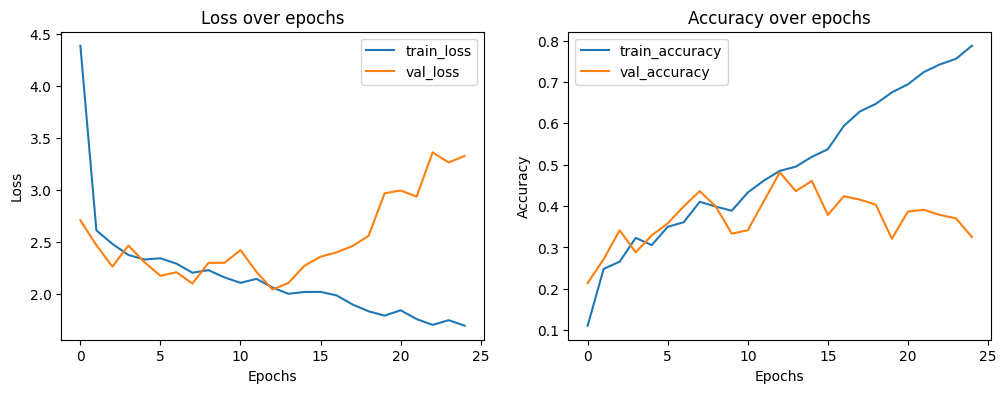

In [86]:
plot_metrics(history)

## Evaluation

In [89]:
def preprocess_and_predict(image_path, model, target_size=(300, 300), top_n=3):
    """
    Preprocess the input image and make a prediction with the model, returning the top_n most probable genres
    along with their softmax probabilities.

    Args:
    - image_path (str): Path to the image file to be tested.
    - model (tf.keras.Model): The trained model for prediction.
    - target_size (tuple): The target size for the image resizing (default is (224, 224)).
    - top_n (int): The number of top predictions to return (default is 3).

    Returns:
    - top_classes (list of tuples): List of top_n predicted class labels and their probabilities.
    """

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)  # Resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image (same as during training)

    # Make prediction
    predictions = model.predict(img_array)

    # Sort predictions and get the indices of the top_n most probable classes
    top_n_indices = np.argsort(predictions[0])[::-1][:top_n]

    # Get class labels
    class_labels = list(train_generator.class_indices.keys())

    # Prepare the list of top classes and their softmax probabilities
    top_classes = [(class_labels[i], predictions[0][i]) for i in top_n_indices]

    # Display the image with the top predicted classes
    plt.imshow(img)
    plt.title(f'Top {top_n} Predicted Genres')
    plt.axis('off')
    plt.show()

    # Return the top_n predicted classes and their softmax probabilities
    return top_classes, predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


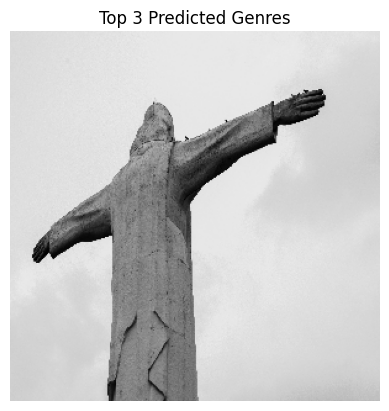

Genre: historical, Probability: 0.4969012141227722
Genre: religious_site, Probability: 0.3188767731189728
Genre: wildlife, Probability: 0.06484740972518921


In [100]:
# Example usage:
image_path = 'statue.jpg'  # Replace with your image path
top_classes, predictions = preprocess_and_predict(image_path, model)

# Print the top 3 classes with their softmax values
for genre, prob in top_classes:
    print(f'Genre: {genre}, Probability: {prob}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


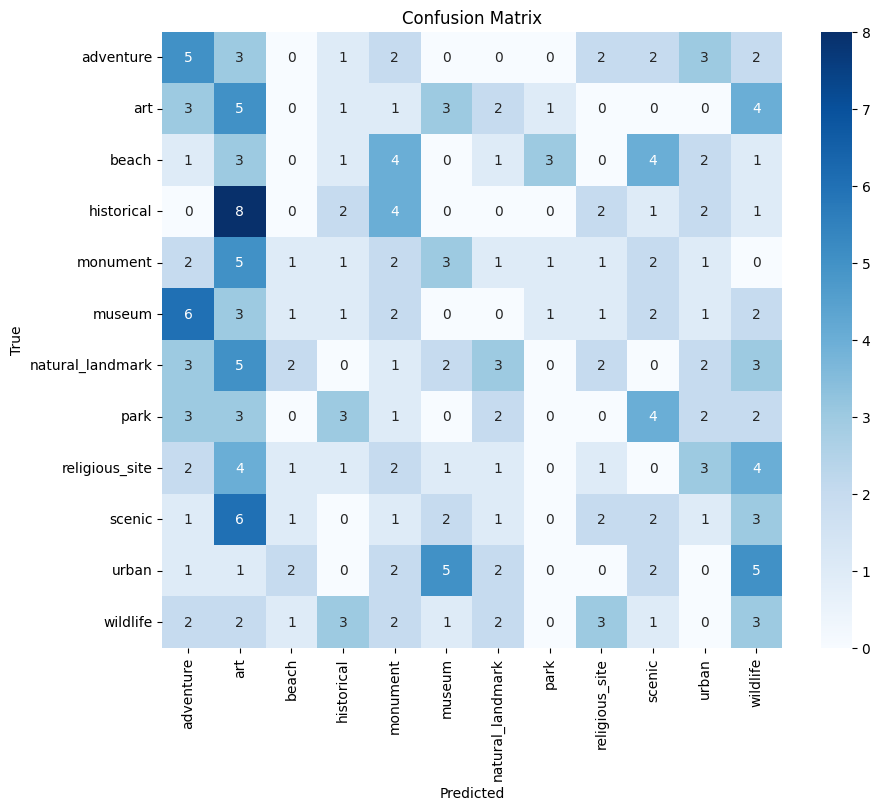

In [96]:
# Step 1: Make predictions on the validation set
validation_predictions = model.predict(validation_generator, verbose=1)

# Convert predictions to class labels (argmax)
predicted_classes = np.argmax(validation_predictions, axis=1)

# Step 2: Get the true labels (ground truth)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Step 3: Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Save Model

In [97]:
model.save('image_genre_classifier.h5')

# Transfer Learning ResNet

## Model

In [107]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze the base model (so its weights won't be updated during training)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,  # ResNet50 as the base model

    # Global average pooling to reduce the dimensionality of the feature maps
    tf.keras.layers.GlobalAveragePooling2D(),

    # # Add a dense layer for the classification task
    # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),

    # # Dropout layer to prevent overfitting
    # tf.keras.layers.Dropout(0.5),

    # Final classification layer with the number of output classes (genres)
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [108]:
model.compile(
    # optimizer=Adam(learning_rate=0.0005),
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 10, 10, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 12)                  │          24,588 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train Model

In [109]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU not found, using CPU instead.")
else:
    print(f"Training on {device_name}")

Training on /device:GPU:0


In [110]:
history = model.fit(
    train_generator,
    epochs=25,  # You can adjust the number of epochs
    validation_data=validation_generator,
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 278ms/step - accuracy: 0.0996 - loss: 2.6411 - val_accuracy: 0.0823 - val_loss: 2.5279
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.1140 - loss: 2.5093 - val_accuracy: 0.1687 - val_loss: 2.4482
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.1607 - loss: 2.4125 - val_accuracy: 0.1276 - val_loss: 2.4184
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.1555 - loss: 2.3612 - val_accuracy: 0.1728 - val_loss: 2.3390
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.1900 - loss: 2.3554 - val_accuracy: 0.1111 - val_loss: 2.3684
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.1925 - loss: 2.3095 - val_accuracy: 0.2099 - val_loss: 2.3017
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.2197 - loss: 2.2642 - val_accuracy: 0.1934 - val_loss: 2.2992
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.2223 - loss: 2.2494 - val_accu

In [111]:
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



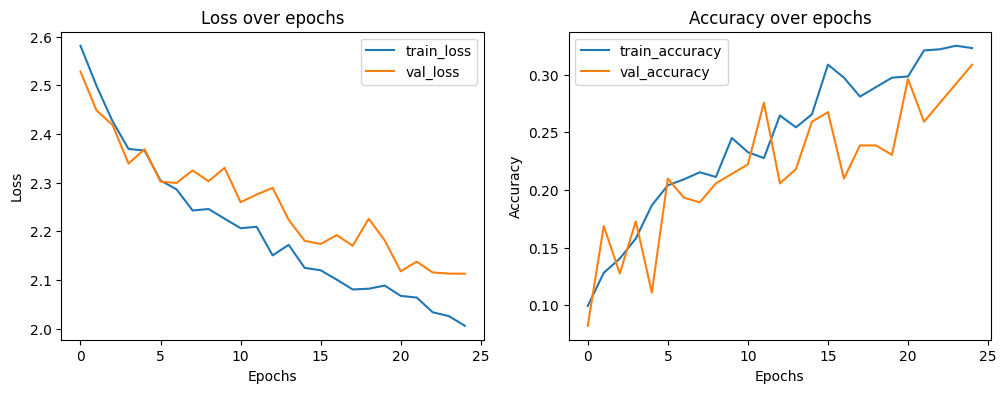

In [112]:
plot_metrics(history)

## Evaluation

In [ ]:
def preprocess_and_predict(image_path, model, target_size=(300, 300), top_n=3):
    """
    Preprocess the input image and make a prediction with the model, returning the top_n most probable genres
    along with their softmax probabilities.

    Args:
    - image_path (str): Path to the image file to be tested.
    - model (tf.keras.Model): The trained model for prediction.
    - target_size (tuple): The target size for the image resizing (default is (224, 224)).
    - top_n (int): The number of top predictions to return (default is 3).

    Returns:
    - top_classes (list of tuples): List of top_n predicted class labels and their probabilities.
    """

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)  # Resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image (same as during training)

    # Make prediction
    predictions = model.predict(img_array)

    # Sort predictions and get the indices of the top_n most probable classes
    top_n_indices = np.argsort(predictions[0])[::-1][:top_n]

    # Get class labels
    class_labels = list(train_generator.class_indices.keys())

    # Prepare the list of top classes and their softmax probabilities
    top_classes = [(class_labels[i], predictions[0][i]) for i in top_n_indices]

    # Display the image with the top predicted classes
    plt.imshow(img)
    plt.title(f'Top {top_n} Predicted Genres')
    plt.axis('off')
    plt.show()

    # Return the top_n predicted classes and their softmax probabilities
    return top_classes, predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


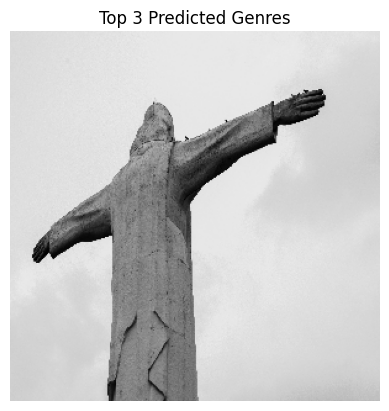

Genre: adventure, Probability: 0.19398443400859833
Genre: wildlife, Probability: 0.14755187928676605
Genre: natural_landmark, Probability: 0.1471618264913559


In [113]:
# Example usage:
image_path = 'statue.jpg'  # Replace with your image path
top_classes, predictions = preprocess_and_predict(image_path, model)

# Print the top 3 classes with their softmax values
for genre, prob in top_classes:
    print(f'Genre: {genre}, Probability: {prob}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step


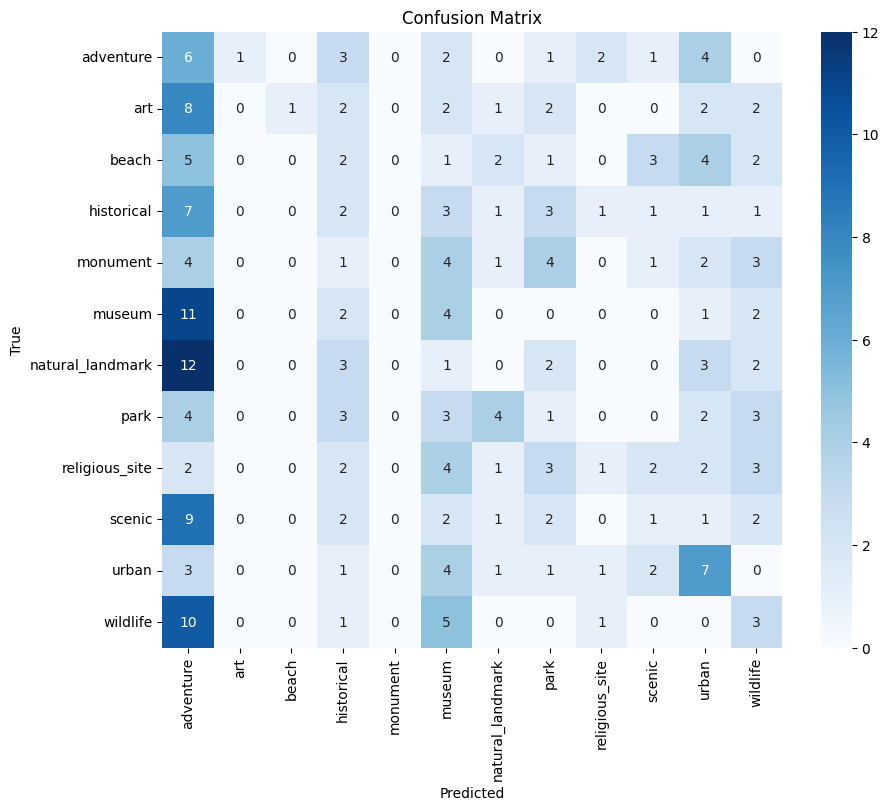

In [114]:
# Step 1: Make predictions on the validation set
validation_predictions = model.predict(validation_generator, verbose=1)

# Convert predictions to class labels (argmax)
predicted_classes = np.argmax(validation_predictions, axis=1)

# Step 2: Get the true labels (ground truth)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Step 3: Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Save Model

In [ ]:
# model.save('image_genre_classifier.h5')